## Lab assignment 02

### Neural Machine Translation in the wild
In the third homework you are supposed to get the best translation you can for the RU-EN translation task.

Basic approach using RNNs as encoder and decoder is implemented for you.

Your ultimate task is to use the techniques we've covered, e.g.

* Optimization enhancements (e.g. learning rate decay)

* Transformer/CNN/<whatever you select> encoder (with or without positional encoding)

* attention/self-attention mechanism (**highly recommended**)

* custom tokenization (BPE units, other subword approaches)

to improve the translation quality.

--------

* __Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__

* Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [1]:
# You might need to install the libraries below. Do it in the desired environment
# if you are working locally.

# ! pip  install subword-nmt
# ! pip install nltk
# ! pip install torchtext

In [2]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

import os
import gc
import tqdm

path_do_data = '../../datasets/Machine_translation_EN_RU/data.txt'
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt -nc
    path_do_data = './data.txt'

Dataset not found locally. Downloading from github.
File ‘data.txt’ already there; not retrieving.



#### Grading criteria

**100%**
- implementation of at least 3 model improvements over baseline
- threshold of 27 BLEU on test corpus
- experimental results and conclusions in human-readable format :)

**70%**
- implementation of at least 2 model improvements over baseline
- threshold of 25 BLEU on test corpus
- experimental results and conclusions in human-readable format :)

**30%**
- implementation of at least 1 model improvement over baseline
- threshold of 21 BLEU on test corpus
- experimental results and conclusions in human-readable format :)


------

#### **Note: Please do not use pretrained machine translation / BERT / LLM checkpoints. All such solutions will be graded at 30% pts.**


### Warning! The code below is deeeeeeeply deprecated and is is provided only as simple guide.
We suggest you to stick to most recent pipelines here, e.g. by Huggingface:
* Example notebook: [link](https://github.com/huggingface/notebooks/blob/main/examples/translation.ipynb)
* Converting your own dataset to specific format: [link](https://discuss.huggingface.co/t/correct-way-to-create-a-dataset-from-a-csv-file/15686/15)

In [3]:
# old deprecated code
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import spacy

import random
import math
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
# from subword_nmt.learn_bpe import learn_bpe
# from subword_nmt.apply_bpe import BPE

### Main part
__Here comes the preprocessing. Do not hesitate to use BPE or more complex preprocessing ;)__

In [4]:
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [5]:
SRC = Field(tokenize=tokenize,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True)

TRG = Field(tokenize=tokenize,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True)

dataset = torchtext.data.TabularDataset(
    path=path_do_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [6]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

In [7]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [8]:
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

In [9]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 9208
Unique tokens in target (en) vocabulary: 6695


Here are tokens from original (RU) corpus:

In [10]:
SRC.vocab.itos[::1000]

['<unk>',
 'городского',
 'hôtes',
 'массажным',
 'lucia',
 '95',
 'olympia',
 'хусейна',
 'дуа',
 'туристы']

And from target (EN) corpus:

In [11]:
TRG.vocab.itos[::1000]

['<unk>',
 'apartamento',
 'cove',
 'cosmopolitan',
 'negombo',
 'sparkling',
 'macedonia']

And here is example from train dataset:

In [12]:
print(vars(train_data.examples[9]))

{'trg': ['located', '600', 'metres', 'from', 'national', 'academic', 'big', 'opera', 'and', 'ballet', 'theatre', ',', 'apartment', 'sweethome', '2', 'offers', 'accommodation', 'in', 'minsk', '.', 'the', 'apartment', 'is', '1', '.', '2', 'km', 'from', 'holy', 'spirit', 'cathedral', '.'], 'src': ['апартаменты', 'sweethome', '2', 'расположены', 'в', 'минске', ',', 'в', '600', 'метрах', 'от', 'большого', 'театра', 'оперы', 'и', 'балета', 'республики', 'беларусь', 'и', 'в', '1', ',', '2', 'км', 'от', 'собора', 'сошествия', 'святого', 'духа', '.']}


Let's check the length distributions:

Length distribution in Train data


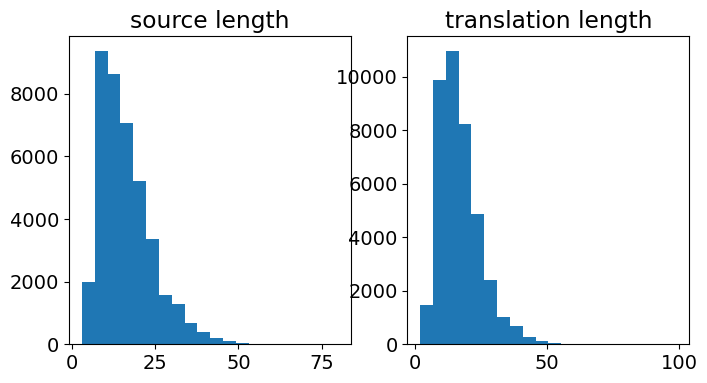

In [13]:
src_length = map(len, [vars(x)['src'] for x in train_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in train_data.examples])

print('Length distribution in Train data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

Length distribution in Test data


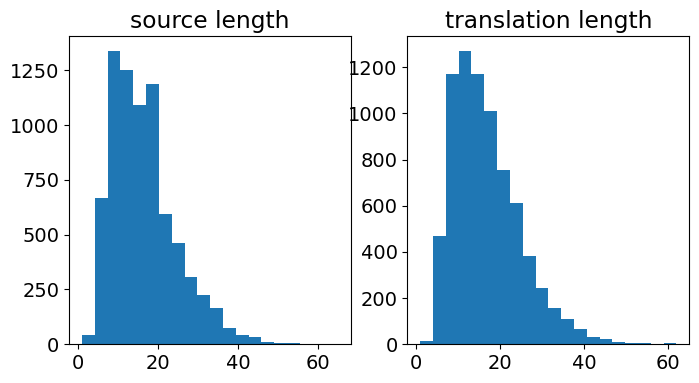

In [14]:
src_length = map(len, [vars(x)['src'] for x in test_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in test_data.examples])

print('Length distribution in Test data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

### Model side
__Here comes simple pipeline of NMT model learning. It almost copies the week02 practice__

In [15]:
device = torch.device('mps' if torch.backends.mps.is_available else 'cuda')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
device

device(type='cuda')

In [17]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    device = device,
    sort_key=_len_sort_key
)

In [18]:
for x in train_iterator:
    break
print(x)
print(x.src.shape, x.trg.shape)


[torchtext.data.batch.Batch of size 128]
	[.trg]:[torch.cuda.LongTensor of size 47x128 (GPU 0)]
	[.src]:[torch.cuda.LongTensor of size 50x128 (GPU 0)]
torch.Size([50, 128]) torch.Size([47, 128])


In [19]:
import my_network
Encoder = my_network.Encoder
Decoder = my_network.Decoder
Seq2Seq = my_network.Seq2Seq

In [20]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)

In [21]:
def init_weights(m):
    # <YOUR CODE HERE>
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)

model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9208, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(6695, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=6695, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [22]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 14,862,119 trainable parameters


In [23]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [24]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()

    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):

        src = batch.src
        trg = batch.trg

        optimizer.zero_grad()

        output = model(src, trg)

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)

        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]

        loss = criterion(output, trg)

        loss.backward()

        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()

            plt.show()


    return epoch_loss / len(iterator)

In [25]:
def evaluate(model, iterator, criterion):

    model.eval()

    epoch_loss = 0

    history = []

    with torch.no_grad():

        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [26]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [27]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

In [28]:
torch.cuda.empty_cache()
gc.collect()

8157

In [29]:
device

device(type='cuda')

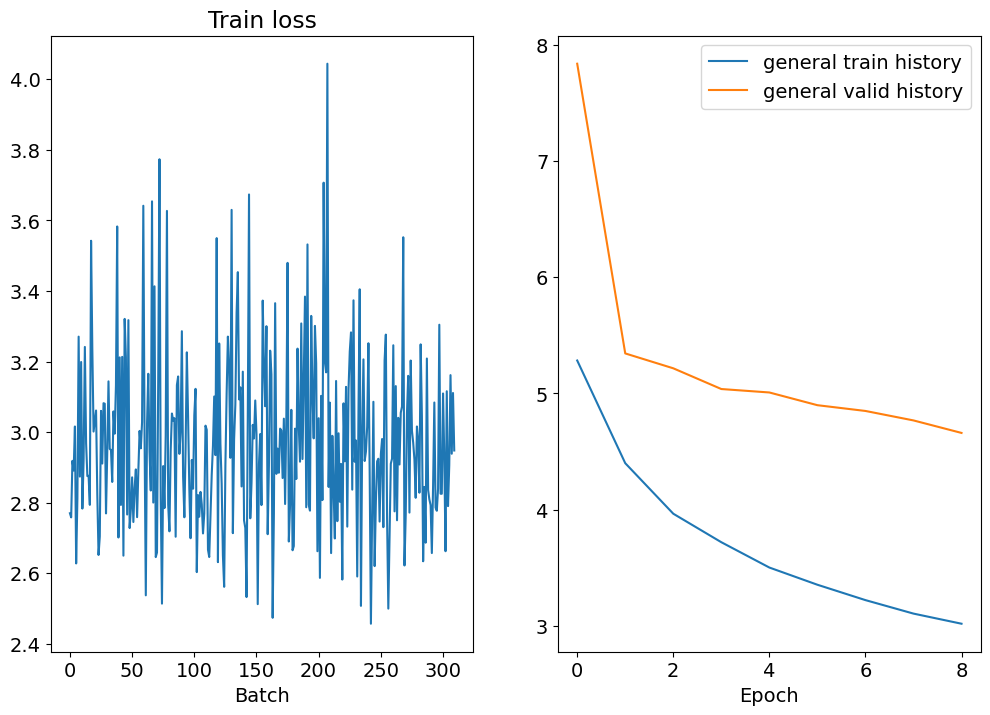

Epoch: 10 | Time: 1m 32s
	Train Loss: 2.967 | Train PPL:  19.428
	 Val. Loss: 4.712 |  Val. PPL: 111.293


In [30]:
for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Обучение заняло 15 минут

__Let's take a look at our network quality__:

In [31]:
# del utils

In [32]:
import utils
import imp
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

/tmp/ipykernel_6713/3680124227.py:2: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


In [33]:
batch = next(iter(test_iterator))

In [34]:
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: a tv is offered .
Generated: the living room is a .

Original: there is the on - site bar at the property .
Generated: guests can enjoy a meal at the bar .



In [35]:
from nltk.translate.bleu_score import corpus_bleu

#     """ Estimates corpora-level BLEU score of model's translations given inp and reference out """
#     translations, _ = model.translate_lines(inp_lines, **flags)
#     # Note: if you experience out-of-memory error, split input lines into batches and translate separately
#     return corpus_bleu([[ref] for ref in out_lines], translations) * 100

In [36]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)

        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

59it [00:03, 18.57it/s]


In [37]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

13.746074413191053

### BPE

In [38]:
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.normalizers import Lowercase
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import BpeTrainer

from nltk.translate.bleu_score import corpus_bleu

from tqdm import tqdm

import bpe_model
imp.reload(bpe_model)

<module 'bpe_model' from '/home/alexansemyachkin/Desktop/jupyter/sanek/bpe_model.py'>

In [39]:
os.makedirs('./bpe', exist_ok=True)

Разделяем на русский и английский языки

In [40]:
with open('./bpe/data_ru.txt', 'w+') as f_src, open('./bpe/data_en.txt', 'w+') as f_trg:
    for line in open('data.txt'):
        trg_line, src_line = line.strip().split('\t')
        f_src.write(src_line + '\n')
        f_trg.write(trg_line + '\n')

Обучаем BPE

In [41]:
tokenizers = {}
for lang in ['ru', 'en']:
    tokenizer = Tokenizer(BPE(unk_token='<unk>'))
    tokenizer.normalizer = Lowercase()
    tokenizer.pre_tokenizer = Whitespace()
    trainer = BpeTrainer(special_tokens=['<unk>', '<pad>', '<sos>', '<eos>'], min_frequency=3, vocab_size=21000)
    file = ['./bpe/data_' + lang + '.txt']
    tokenizer.train(file, trainer)
    tokenizer.save('./bpe/trained_tokenizer_' + lang + '.json')
    tokenizers[lang] = tokenizer

Далее повторение пайплайна бэйзлайна

In [42]:
ind_tokenizers = {
    'ru': lambda input: tokenizers['ru'].encode(input).ids,
    'en': lambda input: tokenizers['en'].encode(input).ids
}

ind_paddings = {
    'ru': tokenizers['ru'].token_to_id('<pad>'),
    'en': tokenizers['en'].token_to_id('<pad>')

}

In [43]:
SRC = Field(tokenize=ind_tokenizers['ru'],
            use_vocab=False,
            pad_token=ind_paddings['ru'],
            batch_first=True)

TRG = Field(tokenize=ind_tokenizers['en'],
            use_vocab=False,
            pad_token=ind_paddings['en'],
            batch_first=True)

dataset = torchtext.data.TabularDataset(
    path=path_do_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [44]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

In [45]:
BATCH_SIZE = 64

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    device = device,
    sort_key=lambda x: len(x.src)
)

In [46]:
for x in train_iterator:
    break
print(x)
print(x.src.shape, x.trg.shape)


[torchtext.data.batch.Batch of size 64]
	[.trg]:[torch.cuda.LongTensor of size 64x37 (GPU 0)]
	[.src]:[torch.cuda.LongTensor of size 64x40 (GPU 0)]
torch.Size([64, 40]) torch.Size([64, 37])


In [47]:
INPUT_DIM = tokenizers['ru'].get_vocab_size()
OUTPUT_DIM = tokenizers['en'].get_vocab_size()
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5


N_EPOCHS = 10
CLIP = 1

In [48]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [50]:
Encoder = bpe_model.Encoder
Decoder = bpe_model.Decoder
Seq2Seq = bpe_model.Seq2Seq

In [51]:
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model = Seq2Seq(enc, dec, device).to(device)

model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(21000, 256)
    (rnn): LSTM(256, 512, num_layers=2, batch_first=True, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(14770, 256)
    (rnn): LSTM(256, 512, num_layers=2, batch_first=True, dropout=0.5)
    (out): Linear(in_features=512, out_features=14770, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [52]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 24,090,546 trainable parameters


In [53]:
PAD_IDX = tokenizers['ru'].token_to_id('<pad>')
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [54]:
def train_epoch(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()

    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):

        src = batch.src
        trg = batch.trg

        optimizer.zero_grad()

        output = model(src, trg)

        # trg = [batch size, trg sent len]
        # output = [batch size, trg sent len, output dim]

        output = output[:, 1:].reshape(-1, output.shape[2])
        trg = trg[:, 1:].reshape(-1)

        # trg = [(trg sent len - 1) * batch size]
        # output = [(trg sent len - 1) * batch size, output dim]

        loss = criterion(output, trg)

        loss.backward()

        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()

            plt.show()


    return epoch_loss / len(iterator)

In [55]:
def evaluate(model, iterator, criterion):

    model.eval()

    epoch_loss = 0

    history = []

    with torch.no_grad():

        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) # turn off teacher forcing

            # trg = [batch size, trg sent len]
            # output = [batch size, trg sent len, output dim]

            output = output[:, 1:].reshape(-1, output.shape[2])
            trg = trg[:, 1:].reshape(-1)

            # trg = [(trg sent len - 1) * batch size]
            # output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [74]:
def train(model, train_iterator, valid_iterator, optimizer, criterion, CLIP, train_history, valid_history, best_valid_loss, save_path):
    for epoch in (range(N_EPOCHS)):

        start_time = time.time()
    
        train_loss = train_epoch(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
        valid_loss = evaluate(model, valid_iterator, criterion)
    
        end_time = time.time()
    
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), save_path)
    
        train_history.append(train_loss)
        valid_history.append(valid_loss)
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [57]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [58]:
train_history = []
valid_history = []

best_valid_loss = float('inf')

In [59]:
torch.cuda.empty_cache()
gc.collect()

0

In [60]:
device

device(type='cuda')

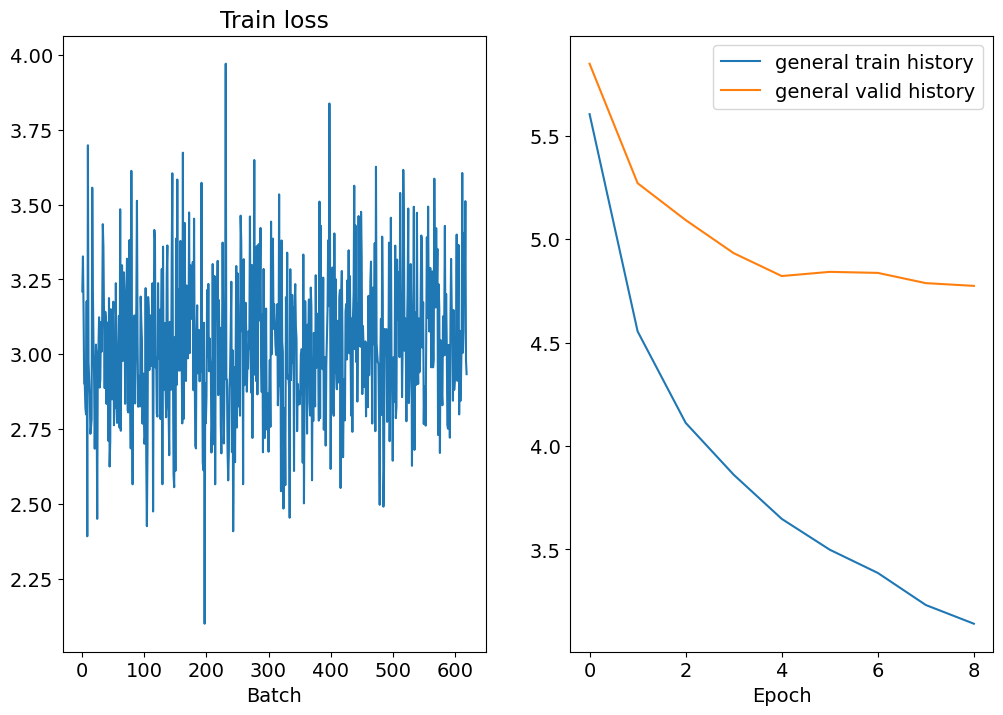

Epoch: 10 | Time: 3m 8s
	Train Loss: 3.029 | Train PPL:  20.682
	 Val. Loss: 4.790 |  Val. PPL: 120.283


In [61]:
train(model, train_iterator, valid_iterator, optimizer, criterion, CLIP, train_history, valid_history, best_valid_loss, 'bpe_model.pt')

Обучение заняло 30 минут

In [62]:
original_text = []
generated_text = []
with torch.no_grad():

    for i, batch in tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) # turn off teacher forcing

        # trg = [batch size, trg sent len]
        # output = [batch size, trg sent len, output dim]

        output = output.argmax(dim=-1)

        original_text.extend(tokenizers['en'].decode_batch(trg.cpu().tolist()))
        generated_text.extend(tokenizers['en'].decode_batch(output[:, 1:].detach().cpu().tolist()))

118it [00:06, 18.50it/s]


In [63]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

42.02638453590985

In [64]:
original_text[:5]

['a pillow menu is available .',
 'you will find a 24 - hour front desk at the property .',
 'the property also offers packed lunches .',
 'some apartments also have a balcony .',
 'a dishwasher is also available .']

In [65]:
generated_text[:5]

['variety of wines . also available . . . . . .',
 'will find a 24 - hour front desk at the property .',
 'property also offers packed lunches . packed lunches . available . .',
 'apartments have a balcony . . . . . . . .',
 'fully equipped kitchen . a . . . . . . .']

Из написанного кода видно, что модель практические не усложнена относительно бейзлайна: по сути, добавлен только кастомный токенайзер и изменены некоторые части кода для совместимости. Хоть время обучения и увеличилось в 2 раза (с 15 до 30 минут), заметен значительный прогресс: модель начала периодически выдавать более естественные переводы, а BLEU выросло с 14 до 41.

### Attention

In [238]:
import attention_model
imp.reload(attention_model)

<module 'attention_model' from '/home/alexansemyachkin/Desktop/jupyter/sanek/attention_model.py'>

In [239]:
BATCH_SIZE = 64

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    device = device,
    sort_key=lambda x: len(x.src)
)

In [240]:
for x in train_iterator:
    break
print(x)
print(x.src.shape, x.trg.shape)


[torchtext.data.batch.Batch of size 64]
	[.trg]:[torch.cuda.LongTensor of size 64x34 (GPU 0)]
	[.src]:[torch.cuda.LongTensor of size 64x41 (GPU 0)]
torch.Size([64, 41]) torch.Size([64, 34])


In [241]:
INPUT_DIM = tokenizers['ru'].get_vocab_size()
OUTPUT_DIM = tokenizers['en'].get_vocab_size()
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5


N_EPOCHS = 10
CLIP = 1

In [242]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [243]:
Encoder = attention_model.Encoder
Decoder = attention_model.Decoder
Attention = attention_model.Attention
Seq2Seq = attention_model.Seq2Seq

In [244]:
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
attn = Attention(HID_DIM)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, device, attn).to(device)

model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(21000, 256)
    (rnn): LSTM(256, 512, num_layers=2, batch_first=True, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(14770, 256)
    (rnn): LSTM(256, 512, num_layers=2, batch_first=True, dropout=0.5)
    (out): Linear(in_features=512, out_features=14770, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (attention): Attention(
      (activation): Tanh()
    )
    (activation): ReLU()
  )
  (attentionn): Attention(
    (activation): Tanh()
  )
)

In [245]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 24,090,546 trainable parameters


In [246]:
PAD_IDX = tokenizers['ru'].token_to_id('<pad>')
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [247]:
train_history = []
valid_history = []

best_valid_loss = float('inf')

In [248]:
torch.cuda.empty_cache()
gc.collect()

8089

In [249]:
device

device(type='cuda')

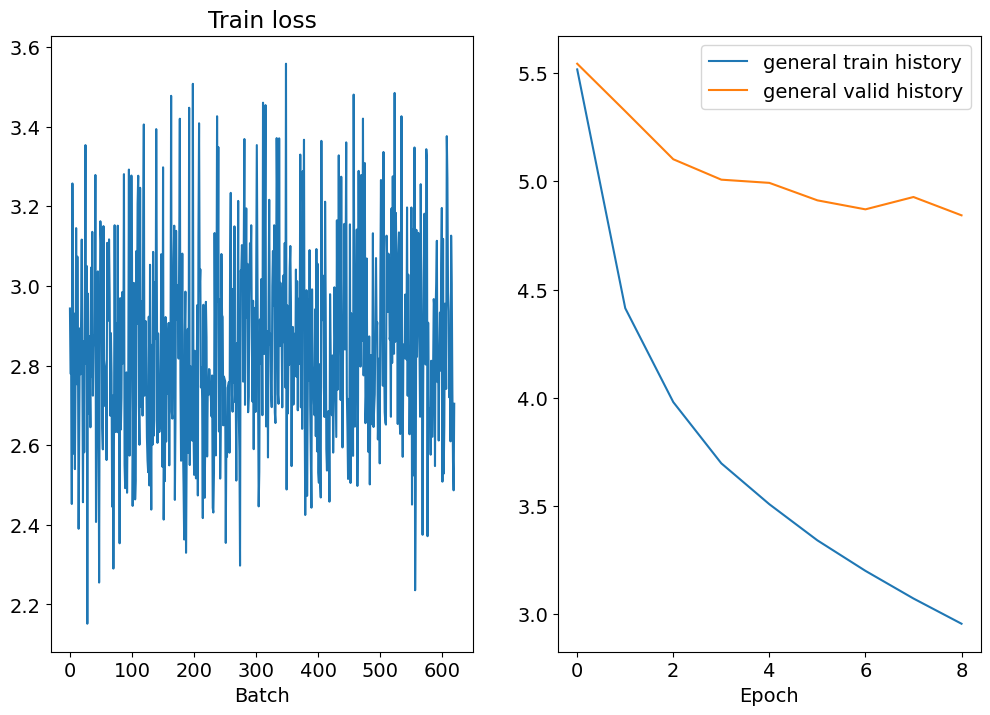

Epoch: 10 | Time: 3m 15s
	Train Loss: 2.846 | Train PPL:  17.224
	 Val. Loss: 4.908 |  Val. PPL: 135.390


In [250]:
train(model, train_iterator, valid_iterator, optimizer, criterion, CLIP, train_history, valid_history, best_valid_loss, 'attention_model.pt')

Обучение заняло 32 минуты

In [251]:
original_text = []
generated_text = []
with torch.no_grad():

    for i, batch in tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) # turn off teacher forcing

        # trg = [batch size, trg sent len]
        # output = [batch size, trg sent len, output dim]

        output = output.argmax(dim=-1)

        original_text.extend(tokenizers['en'].decode_batch(trg.cpu().tolist()))
        generated_text.extend(tokenizers['en'].decode_batch(output[:, 1:].detach().cpu().tolist()))

118it [00:06, 17.69it/s]


In [252]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

41.780427904144794

In [253]:
original_text[:5]

['a pillow menu is available .',
 'you will find a 24 - hour front desk at the property .',
 'the property also offers packed lunches .',
 'some apartments also have a balcony .',
 'a dishwasher is also available .']

In [254]:
generated_text[:5]

['strong you . . . . . . . . . .',
 'will find a 24 - hour front desk . the property .',
 'hosts packed lunches . . . . . . . . .',
 'have a balcony . . . . . . . . .',
 'kitchen . . . there is a dishwasher . . . .']

Как видно, и время обучение, и качество остались примерно такими же. Возможно, различия могут проявиться на большем объеме данных, либо при сравнении на более сложных текстах.